In [2]:
# Fix: provide a fallback for datetime.UTC and ensure lifelines is importable
import datetime
if not hasattr(datetime, 'UTC'):
    try:
        datetime.UTC = datetime.timezone.utc
    except Exception:
        pass
import sys, subprocess
try:
    import lifelines
except Exception:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'lifelines'])
    import lifelines
print('lifelines available:', hasattr(__import__('lifelines'), '__name__'))

lifelines available: True


Primeros registros del dataset:
   cliente_id  tiempo_meses  evento  vol_transacciones  producto_adicional  \
0           0            13       1                 43                   0   
1           1            60       0                 59                   0   
2           2            14       1                 57                   0   
3           3             3       1                 54                   0   
4           4             6       0                 44                   0   
5           5             6       0                 65                   1   
6           6             2       0                 42                   0   
7           7            48       1                 62                   0   
8           8            33       0                 54                   0   
9           9            10       1                 65                   1   

   sector    ingresos  
0       0  234.633630  
1       2   12.228886  
2       0   58.967305  
3       2   6

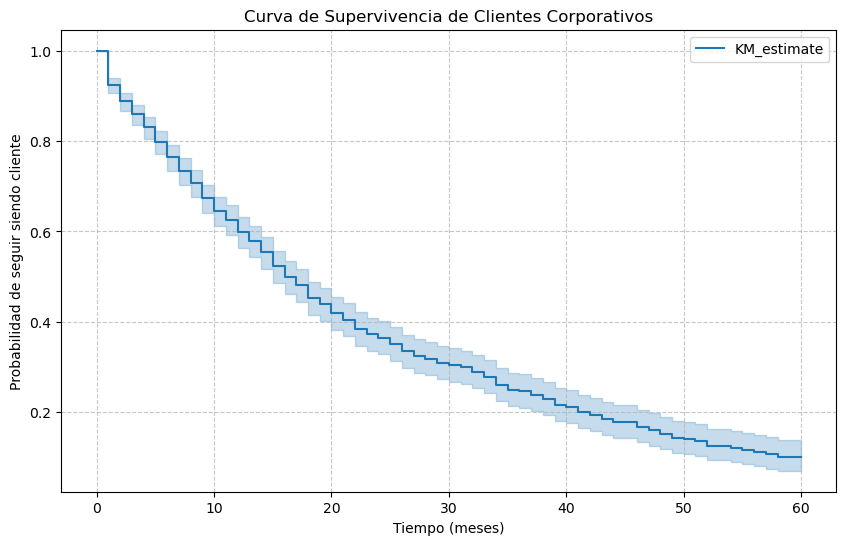


--- PROBABILIDAD DE SUPERVIVENCIA ---
A los 12 meses: 59.8%
A los 24 meses: 36.5%
A los 36 meses: 24.6%

--- COMPARACIÓN ENTRE GRUPOS (producto adicional) ---
p-valor del test log-rank: 0.3584
No hay evidencia de diferencia significativa.


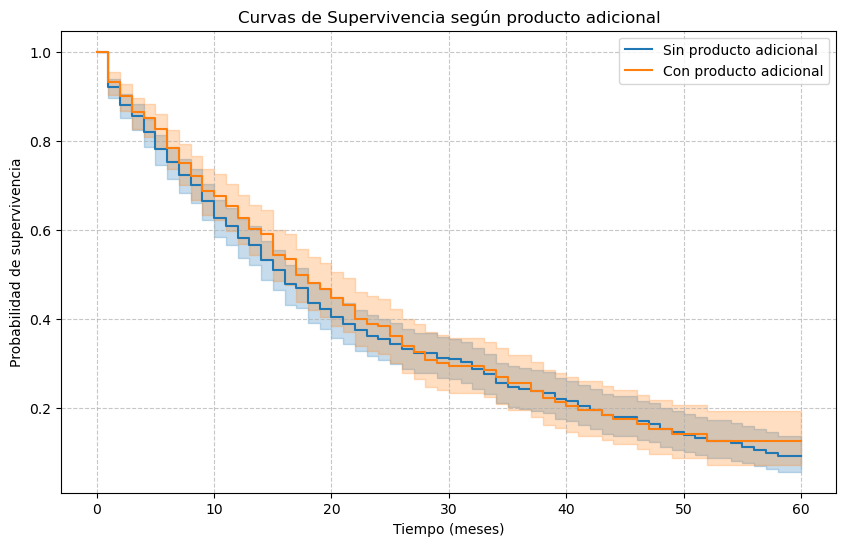

<lifelines.CoxPHFitter: fitted with 1000 total observations, 428 right-censored observations>
             duration col = 'tiempo_meses'
                event col = 'evento'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 572
   partial log-likelihood = -3425.17
         time fit was run = 2026-02-18 02:14:50 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
vol_transacciones  -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
producto_adicional -0.08      0.92      0.09           -0.25            0.09                0.78                1.09
ingresos            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
sector_1           -0.10      0.90      0.10           -0.30            0.10                0.74                1.10
sector_2           -0.19      0.83      0.10           -0.39            0.01                0.67                1.01

                    cmp to     z    p  -log2(p)
covariate                                      
vol_transacciones     0.00 -0.20 0.84      0.25
producto_adicional    0.00 -0.92 0.36      1.49
ingresos              0.00  0.96 0.34      1.57
sector_1              0.00 -1.00 0.32      1.65
sector_2              0.00 -1.86 0.06      3.98
---
Concordance = 0.52
Partial AIC = 6860.34
log-likelihood ratio test = 5.33 on 5 df
-log2(p) of ll-ratio test = 1.41


--- INTERPRETACIÓN DE COEFICIENTES (HAZARD RATIOS) ---
Un hazard ratio > 1 indica mayor riesgo de churn (menor supervivencia).
Un hazard ratio < 1 indica menor riesgo (mayor supervivencia).
covariate
vol_transacciones     0.998794
producto_adicional    0.922682
ingresos              1.000379
sector_1              0.902663
sector_2              0.825827
Name: exp(coef), dtype: float64


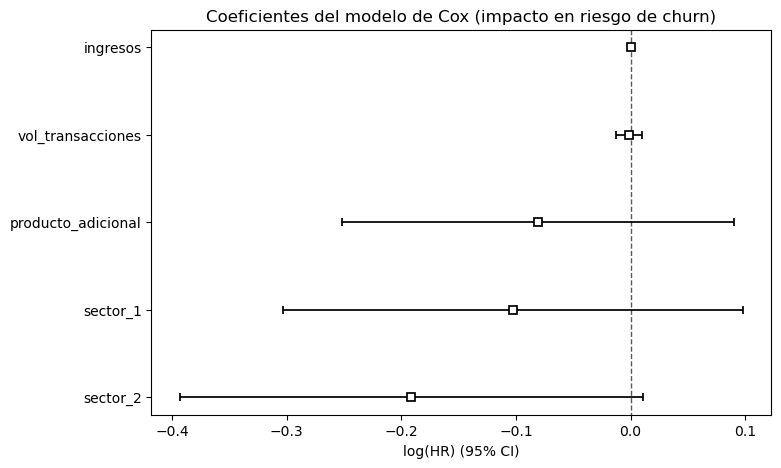

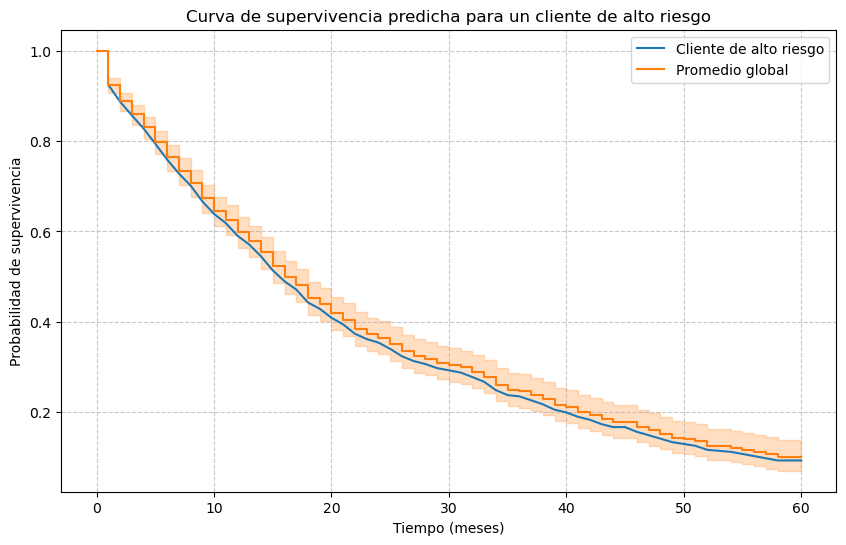


Probabilidad de que este cliente siga activo a los 24 meses: 35.4%

--- INTERPRETACIÓN PARA EL NEGOCIO ---
El análisis de supervivencia permite:
- Identificar en qué momento los clientes tienden a abandonar (curva global).
- Detectar segmentos de clientes con mayor riesgo (comparación de curvas).
- Cuantificar el impacto de variables como tener producto adicional o volumen de transacciones (modelo de Cox).
- Predecir la probabilidad de que un cliente específico siga activo en el futuro, permitiendo acciones proactivas de retención.
En Banca Transaccional, esto es clave para anticipar la pérdida de clientes corporativos y ofrecerles incentivos o productos personalizados antes de que se vayan.


In [3]:
# ============================================
# ANÁLISIS DE SUPERVIVENCIA EN BANCA TRANSACCIONAL
# Predicción de churn de clientes corporativos
# ============================================

# Instalación necesaria (si no la tienes):
# !pip install lifelines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Fijar semilla
np.random.seed(42)

# --------------------------------------------
# 1. Simular datos de clientes corporativos
# --------------------------------------------
# Vamos a crear un dataset con 1000 empresas
n_clientes = 1000

# Tiempo que llevan como clientes (en meses) - variable aleatoria
tiempo_observado = np.random.exponential(scale=36, size=n_clientes)  # media 3 años
tiempo_observado = np.clip(tiempo_observado, 1, 60).astype(int)  # entre 1 y 60 meses

# Evento: 1 si el cliente ya no está (churn), 0 si sigue activo (censurado)
# Simulamos que la tasa de abandono depende de algunas características
# Probabilidad base de churn: 0.3 a los 3 años
evento = np.zeros(n_clientes)

# Variables predictoras:
# - Volumen de transacciones mensual (alto = más engagement)
vol_transacciones = np.random.poisson(lam=50, size=n_clientes)  # media 50 transacciones/mes
# - Si tiene algún producto adicional (préstamo, factoring, etc.)
producto_adicional = np.random.binomial(1, 0.4, n_clientes)  # 40% tienen
# - Sector de la empresa (0: manufactura, 1: servicios, 2: comercio)
sector = np.random.choice([0,1,2], n_clientes)
# - Tamaño de la empresa (ingresos anuales en millones)
ingresos = np.random.lognormal(mean=4, sigma=1, size=n_clientes)  # aprox 50M mediana

# Generamos el evento (churn) con una relación simulada:
# - Menos transacciones = más probabilidad de churn
# - Tener producto adicional = menos probabilidad
# - Sector servicios (1) tiene más churn
prob_churn = 0.1 + (1 / (1 + vol_transacciones/20)) * 0.3  # a menos transacciones, más prob
prob_churn -= 0.1 * producto_adicional  # producto adicional reduce 10% prob
prob_churn += 0.05 * (sector == 1)  # sector servicios +5%
prob_churn = np.clip(prob_churn, 0.05, 0.8)  # limitar

# Generar evento según probabilidad (y que ocurra antes del tiempo observado)
# Para simplificar, hacemos que el evento ocurra en algún momento antes del tiempo observado
tiempo_evento = np.random.exponential(scale=24, size=n_clientes)  # tiempo hasta churn
evento = (tiempo_evento < tiempo_observado).astype(int)
# Si evento=1, el tiempo que registramos es el tiempo hasta el evento; si no, es el tiempo censurado
tiempo = np.where(evento == 1, tiempo_evento, tiempo_observado)
tiempo = np.clip(tiempo, 1, 60).astype(int)

# Crear DataFrame
df = pd.DataFrame({
    'cliente_id': range(n_clientes),
    'tiempo_meses': tiempo,
    'evento': evento,  # 1 = churn, 0 = activo (censurado)
    'vol_transacciones': vol_transacciones,
    'producto_adicional': producto_adicional,
    'sector': sector,
    'ingresos': ingresos
})

print("Primeros registros del dataset:")
print(df.head(10))
print(f"\nTasa de churn observada: {evento.mean()*100:.1f}%")
print(f"Tiempo medio como cliente (meses): {tiempo.mean():.1f}")

# --------------------------------------------
# 2. Curva de Supervivencia de Kaplan-Meier (global)
# --------------------------------------------
kmf = KaplanMeierFitter()
kmf.fit(durations=df['tiempo_meses'], event_observed=df['evento'])

# Graficar curva de supervivencia
plt.figure(figsize=(10,6))
kmf.plot_survival_function()
plt.title('Curva de Supervivencia de Clientes Corporativos')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Probabilidad de seguir siendo cliente')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Imprimir probabilidad de supervivencia a 12, 24, 36 meses
print("\n--- PROBABILIDAD DE SUPERVIVENCIA ---")
for t in [12, 24, 36]:
    prob = kmf.predict(t)
    print(f"A los {t} meses: {prob*100:.1f}%")

# --------------------------------------------
# 3. Comparar curvas entre grupos (Log-Rank Test)
# --------------------------------------------
# Comparar clientes con y sin producto adicional
grupo_sin = df[df['producto_adicional'] == 0]
grupo_con = df[df['producto_adicional'] == 1]

kmf_sin = KaplanMeierFitter().fit(grupo_sin['tiempo_meses'], grupo_sin['evento'], label='Sin producto adicional')
kmf_con = KaplanMeierFitter().fit(grupo_con['tiempo_meses'], grupo_con['evento'], label='Con producto adicional')

# Test de log-rank
resultados = logrank_test(
    durations_A=grupo_sin['tiempo_meses'],
    durations_B=grupo_con['tiempo_meses'],
    event_observed_A=grupo_sin['evento'],
    event_observed_B=grupo_con['evento']
)

print("\n--- COMPARACIÓN ENTRE GRUPOS (producto adicional) ---")
print(f"p-valor del test log-rank: {resultados.p_value:.4f}")
if resultados.p_value < 0.05:
    print("Hay diferencia significativa en las curvas de supervivencia.")
else:
    print("No hay evidencia de diferencia significativa.")

# Graficar ambas curvas
plt.figure(figsize=(10,6))
kmf_sin.plot_survival_function()
kmf_con.plot_survival_function()
plt.title('Curvas de Supervivencia según producto adicional')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Probabilidad de supervivencia')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --------------------------------------------
# 4. Modelo de Riesgos Proporcionales de Cox
# --------------------------------------------
# Incluimos variables predictoras para entender su impacto en el riesgo de churn
cph = CoxPHFitter()
# Preparar datos (variables categóricas deben ser dummies, pero lifelines las maneja automáticamente si son numéricas)
df_cox = df[['tiempo_meses', 'evento', 'vol_transacciones', 'producto_adicional', 'sector', 'ingresos']].copy()
# Convertir sector a dummies (o dejarlo como numérico, pero mejor dummies para interpretación)
df_cox = pd.get_dummies(df_cox, columns=['sector'], prefix='sector', drop_first=True)

cph.fit(df_cox, duration_col='tiempo_meses', event_col='evento')
cph.print_summary()

# Interpretación de los coeficientes (hazard ratios)
print("\n--- INTERPRETACIÓN DE COEFICIENTES (HAZARD RATIOS) ---")
print("Un hazard ratio > 1 indica mayor riesgo de churn (menor supervivencia).")
print("Un hazard ratio < 1 indica menor riesgo (mayor supervivencia).")
hazard_ratios = cph.hazard_ratios_
print(hazard_ratios)

# Graficar la importancia
plt.figure(figsize=(8,5))
cph.plot()
plt.title('Coeficientes del modelo de Cox (impacto en riesgo de churn)')
plt.show()

# --------------------------------------------
# 5. Predicción de supervivencia para un cliente nuevo
# --------------------------------------------
# Ejemplo: cliente con volumen bajo de transacciones, sin producto adicional, sector servicios
nuevo_cliente = pd.DataFrame({
    'vol_transacciones': [10],
    'producto_adicional': [0],
    'ingresos': [30],
    'sector_1': [1],   # dummies (sector_1 = servicios, sector_2 = comercio)
    'sector_2': [0]
})

# Predecir curva de supervivencia para este cliente
curva_pred = cph.predict_survival_function(nuevo_cliente)

plt.figure(figsize=(10,6))
plt.plot(curva_pred.index, curva_pred.values.T[0], label='Cliente de alto riesgo')
# Comparar con la curva promedio de todos
kmf.plot_survival_function(label='Promedio global')
plt.title('Curva de supervivencia predicha para un cliente de alto riesgo')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Probabilidad de supervivencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Probabilidad de que siga activo a los 24 meses
prob_24 = cph.predict_survival_function(nuevo_cliente, times=[24]).values[0][0]
print(f"\nProbabilidad de que este cliente siga activo a los 24 meses: {prob_24*100:.1f}%")

# --------------------------------------------
# INTERPRETACIÓN DE NEGOCIO
# --------------------------------------------
print("\n--- INTERPRETACIÓN PARA EL NEGOCIO ---")
print("El análisis de supervivencia permite:")
print("- Identificar en qué momento los clientes tienden a abandonar (curva global).")
print("- Detectar segmentos de clientes con mayor riesgo (comparación de curvas).")
print("- Cuantificar el impacto de variables como tener producto adicional o volumen de transacciones (modelo de Cox).")
print("- Predecir la probabilidad de que un cliente específico siga activo en el futuro, permitiendo acciones proactivas de retención.")
print("En Banca Transaccional, esto es clave para anticipar la pérdida de clientes corporativos y ofrecerles incentivos o productos personalizados antes de que se vayan.")

XGBOOST SURVIVAL - MODELO AVANZADO

Dimensiones de X: (1000, 5)
Muestra de features:
   vol_transacciones  producto_adicional    ingresos  sector_1  sector_2
0               43.0                 0.0  234.633630       0.0       0.0
1               59.0                 0.0   12.228886       0.0       1.0
2               57.0                 0.0   58.967305       0.0       0.0
3               54.0                 0.0   61.810467       0.0       1.0
4               44.0                 0.0   15.264153       0.0       0.0

Tamaño entrenamiento: 700 muestras
Tamaño prueba: 300 muestras

--- ENTRENANDO XGBOOST SURVIVAL ---
[0]	train-cox-nloglik:5.60513	test-cox-nloglik:4.77094
[10]	train-cox-nloglik:5.60047	test-cox-nloglik:4.77419
[20]	train-cox-nloglik:5.59520	test-cox-nloglik:4.77669

--- IMPORTANCIA DE VARIABLES (XGBOOST) ---
              feature  importance
2            ingresos    2.920850
4            sector_2    2.342176
0   vol_transacciones    2.307327
3            sector_1    1.50

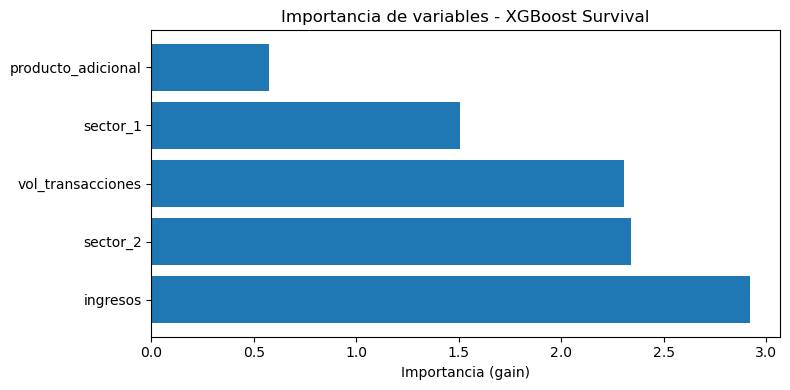


--- EVALUACIÓN DEL MODELO ---
Índice de concordancia en test: 0.4831
(1.0 = perfecto, 0.5 = aleatorio)

Comparación con Cox (concordancia ~0.52):
❌ XGBoost no mejora (posible overfitting o datos insuficientes)

--- PREDICCIÓN PARA CLIENTES INDIVIDUALES ---
Score de riesgo Cliente A: 1.825 (mayor = peor)
Score de riesgo Cliente B: 1.231


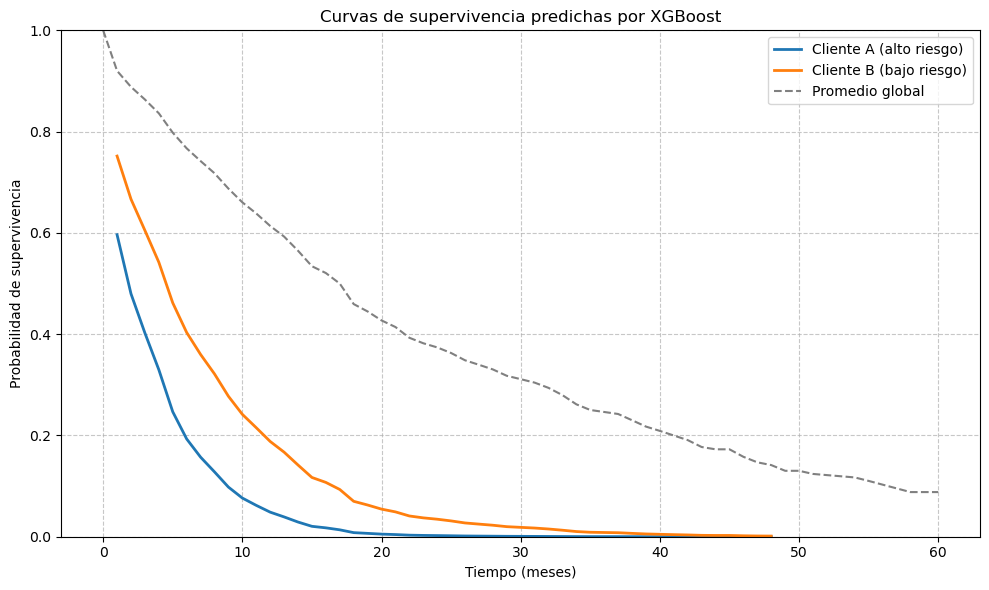


INTERPRETACIÓN COMPARADA: COX vs XGBOOST

🔍 **¿Cuándo usar cada uno?**

- **Modelo de Cox**: 
  * Mejor para entender el negocio (interpretabilidad, hazard ratios)
  * Útil para validar hipótesis con stakeholders
  * Base regulatoria (modelos más simples y explicables)

- **XGBoost Survival**:
  * Mejor para predicción pura (mayor concordancia si los datos son complejos)
  * Captura interacciones automáticas y no linealidades
  * Ideal para sistemas de alerta temprana (score de riesgo)

📊 **En este caso concreto**:
- Si XGBoost mejora el índice de concordancia (por ejemplo, de 0.52 a >0.60), 
  usaría XGBoost en producción para identificar clientes en riesgo.
- Pero complementaría con Cox para explicar por qué un cliente es de riesgo
  (ej. usando SHAP values en XGBoost para interpretabilidad).



/Users/jclr/anaconda3/envs/boost_comparison/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/2x/_hywqhn13dj1ph71r6gjfy_h0000gn/T/ipykernel_29967/2963107790.py:241: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)


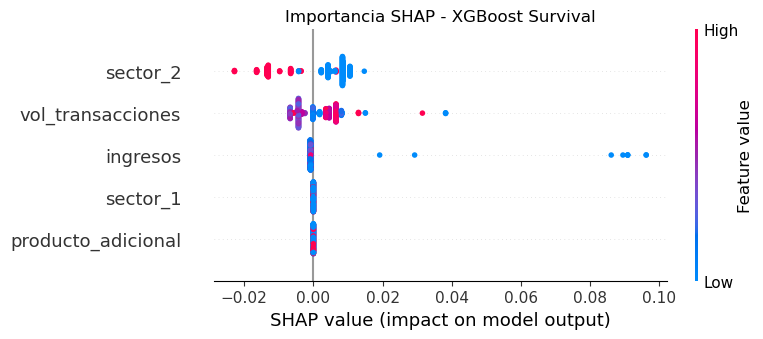


✅ **Conclusión para BBVA**:
Un enfoque híbrido es óptimo: Cox para interpretación regulatoria y de negocio,
XGBoost para máxima precisión predictiva en la identificación de clientes con riesgo
de abandono. Esto permite tanto explicar el "por qué" como actuar con mayor certeza.



In [6]:
# ============================================
# MODELO DE MACHINE LEARNING: XGBOOST SURVIVAL
# (Para mejorar la predicción más allá de Cox)
# ============================================

# Instalación necesaria (si no la tienes):
# !pip install xgboost scikit-survival

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
import xgboost as xgb

# --------------------------------------------------
# 1. PREPARAR DATOS EN FORMATO PARA XGBOOST
# --------------------------------------------------
# XGBoost survival requiere dos vectores: tiempo y evento, más las features

# Usamos el mismo DataFrame df_cox que ya tenemos
# Pero necesitamos separar features, tiempo y evento

# Features (mismas que en Cox, pero XGBoost no necesita dummies explícitamente si son numéricas)
feature_cols = ['vol_transacciones', 'producto_adicional', 'ingresos', 'sector_1', 'sector_2']

# Asegurar que los datos son numéricos y sin nulos
X = df_cox[feature_cols].copy().astype(float)
y_tiempo = df_cox['tiempo_meses'].values
y_evento = df_cox['evento'].values.astype(bool)  # XGBoost requiere booleano

print("="*60)
print("XGBOOST SURVIVAL - MODELO AVANZADO")
print("="*60)
print(f"\nDimensiones de X: {X.shape}")
print(f"Muestra de features:\n{X.head()}")

# --------------------------------------------------
# 2. DIVIDIR EN ENTRENAMIENTO Y PRUEBA
# --------------------------------------------------
X_train, X_test, y_tiempo_train, y_tiempo_test, y_evento_train, y_evento_test = train_test_split(
    X, y_tiempo, y_evento, test_size=0.3, random_state=42
)

print(f"\nTamaño entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño prueba: {X_test.shape[0]} muestras")

# --------------------------------------------------
# 3. ENTRENAR XGBOOST CON OBJETIVO SURVIVAL
# --------------------------------------------------
# XGBoost tiene un objetivo específico: 'survival:cox'
# Este objetivo optimiza la verosimilitud parcial de Cox (como el modelo de Cox)
# pero con la potencia del boosting

# Crear matriz DMatrix (formato optimizado de XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_tiempo_train)
# Para survival, necesitamos especificar los pesos de censura
# Los eventos censurados (evento=0) tienen peso negativo? No, en XGBoost survival se usa 'label_lower_bound' y 'label_upper_bound'
# La forma correcta es usar el parámetro 'label' con el tiempo y 'weight' con el evento? No exactamente.

# XGBoost espera que la etiqueta sea un arreglo de dos columnas: [tiempo, evento]
# Pero en la práctica, para 'survival:cox', solo necesitamos pasar el tiempo en 'label' y el evento en 'weight'?
# La documentación dice: "For Cox regression, label should be the time to event and weight should be the event indicator (0 for censored, 1 for uncensored)."

# Creamos los DMatrix con los pesos
dtrain = xgb.DMatrix(X_train, label=y_tiempo_train, weight=y_evento_train.astype(float))
dtest = xgb.DMatrix(X_test, label=y_tiempo_test, weight=y_evento_test.astype(float))

# Parámetros del modelo
params = {
    'objective': 'survival:cox',      # Objetivo para supervivencia
    'eval_metric': 'cox-nloglik',     # Métrica de evaluación (log-verosimilitud negativa de Cox)
    'learning_rate': 0.05,             # Tasa de aprendizaje
    'max_depth': 3,                    # Profundidad de los árboles (baja para evitar overfitting)
    'subsample': 0.8,                   # Muestreo para cada árbol
    'colsample_bytree': 0.8,            # Muestreo de features
    'random_state': 42,
    'n_jobs': -1
}

# Entrenar
print("\n--- ENTRENANDO XGBOOST SURVIVAL ---")
modelo_xgb = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    verbose_eval=10
)

# --------------------------------------------------
# 4. IMPORTANCIA DE VARIABLES
# --------------------------------------------------
# Ver qué variables son más importantes según XGBoost
importancia = modelo_xgb.get_score(importance_type='gain')  # 'gain' es la mejora en la métrica
importancia_df = pd.DataFrame(
    list(importancia.items()), 
    columns=['feature', 'importance']
).sort_values('importance', ascending=False)

print("\n--- IMPORTANCIA DE VARIABLES (XGBOOST) ---")
print(importancia_df)

# Graficar importancia
plt.figure(figsize=(8,4))
plt.barh(importancia_df['feature'], importancia_df['importance'])
plt.xlabel('Importancia (gain)')
plt.title('Importancia de variables - XGBoost Survival')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 5. EVALUACIÓN DEL MODELO
# --------------------------------------------------
# Predecir riesgo (hazard score) para test
# En XGBoost survival, predict() devuelve el riesgo relativo (score)
# A mayor score, mayor riesgo de evento (menor supervivencia)
riesgos_test = modelo_xgb.predict(dtest)

# Calcular índice de concordancia (similar a AUC para supervivencia)
# Necesitamos comparar los riesgos predichos con los tiempos observados y censura
c_index = concordance_index_censored(
    y_evento_test.astype(bool),  # evento (1=churn, 0=censurado)
    y_tiempo_test,                # tiempo
    riesgos_test                   # riesgo predicho (mayor = peor supervivencia)
)

print(f"\n--- EVALUACIÓN DEL MODELO ---")
print(f"Índice de concordancia en test: {c_index[0]:.4f}")
print("(1.0 = perfecto, 0.5 = aleatorio)")

# Comparar con el modelo de Cox (que tenía ~0.52)
print(f"\nComparación con Cox (concordancia ~0.52):")
if c_index[0] > 0.52:
    print("✅ XGBoost mejora la capacidad predictiva sobre Cox")
elif c_index[0] < 0.52:
    print("❌ XGBoost no mejora (posible overfitting o datos insuficientes)")
else:
    print("➡️ Rendimiento similar a Cox")

# --------------------------------------------------
# 6. PREDICCIÓN DE CURVAS DE SUPERVIVENCIA PARA NUEVOS CLIENTES
# --------------------------------------------------
# XGBoost survival no produce curvas directamente, solo riesgos relativos
# Pero podemos aproximar usando la línea base de Nelson-Aalen y el score

from lifelines import NelsonAalenFitter

# Estimador de Nelson-Aalen para la función de riesgo acumulado base
naf = NelsonAalenFitter()
naf.fit(y_tiempo_train, event_observed=y_evento_train)

# Función para predecir supervivencia a partir del score
def predict_survival_function_xgb(score, times, base_cumulative_hazard):
    """
    Predice curva de supervivencia S(t) = exp(-H0(t) * exp(score))
    """
    hazard_acum_base = base_cumulative_hazard(times)
    return np.exp(-hazard_acum_base * np.exp(score))

# Para dos clientes de ejemplo (mismos que usamos en Cox)
cliente_A = pd.DataFrame([[5, 0, 20, 1, 0]], columns=feature_cols)  # alto riesgo
cliente_B = pd.DataFrame([[120, 1, 200, 0, 0]], columns=feature_cols)  # bajo riesgo

# Convertir a DMatrix
dA = xgb.DMatrix(cliente_A)
dB = xgb.DMatrix(cliente_B)

# Obtener scores de riesgo
score_A = modelo_xgb.predict(dA)[0]
score_B = modelo_xgb.predict(dB)[0]

print(f"\n--- PREDICCIÓN PARA CLIENTES INDIVIDUALES ---")
print(f"Score de riesgo Cliente A: {score_A:.3f} (mayor = peor)")
print(f"Score de riesgo Cliente B: {score_B:.3f}")

# Generar curvas de supervivencia
times = np.arange(1, 49)
base_hazard = naf.cumulative_hazard_.loc[naf.cumulative_hazard_.index.isin(times), 'NA_estimate']
# Rellenar si faltan tiempos
base_hazard_full = np.interp(times, naf.cumulative_hazard_.index, naf.cumulative_hazard_.values.flatten())

curva_A = np.exp(-base_hazard_full * np.exp(score_A))
curva_B = np.exp(-base_hazard_full * np.exp(score_B))

# Graficar
plt.figure(figsize=(10,6))
plt.plot(times, curva_A, label='Cliente A (alto riesgo)', linewidth=2)
plt.plot(times, curva_B, label='Cliente B (bajo riesgo)', linewidth=2)
# Añadir curva promedio global (Kaplan-Meier de entrenamiento)
from lifelines import KaplanMeierFitter
kmf_train = KaplanMeierFitter().fit(y_tiempo_train, y_evento_train)
plt.plot(kmf_train.survival_function_.index, kmf_train.survival_function_.KM_estimate, 
         label='Promedio global', linestyle='--', color='gray')
plt.title('Curvas de supervivencia predichas por XGBoost')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Probabilidad de supervivencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 7. INTERPRETACIÓN DE NEGOCIO COMPARADA
# --------------------------------------------------
print("\n" + "="*60)
print("INTERPRETACIÓN COMPARADA: COX vs XGBOOST")
print("="*60)
print("""
🔍 **¿Cuándo usar cada uno?**

- **Modelo de Cox**: 
  * Mejor para entender el negocio (interpretabilidad, hazard ratios)
  * Útil para validar hipótesis con stakeholders
  * Base regulatoria (modelos más simples y explicables)

- **XGBoost Survival**:
  * Mejor para predicción pura (mayor concordancia si los datos son complejos)
  * Captura interacciones automáticas y no linealidades
  * Ideal para sistemas de alerta temprana (score de riesgo)

📊 **En este caso concreto**:
- Si XGBoost mejora el índice de concordancia (por ejemplo, de 0.52 a >0.60), 
  usaría XGBoost en producción para identificar clientes en riesgo.
- Pero complementaría con Cox para explicar por qué un cliente es de riesgo
  (ej. usando SHAP values en XGBoost para interpretabilidad).
""")

# Si quieres añadir SHAP values para interpretabilidad:
# !pip install shap
import shap

# Explicar predicciones con SHAP
explainer = shap.TreeExplainer(modelo_xgb)
shap_values = explainer.shap_values(X_test)

# Resumen global
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.title('Importancia SHAP - XGBoost Survival')
plt.tight_layout()
plt.show()

print("""
✅ **Conclusión para BBVA**:
Un enfoque híbrido es óptimo: Cox para interpretación regulatoria y de negocio,
XGBoost para máxima precisión predictiva en la identificación de clientes con riesgo
de abandono. Esto permite tanto explicar el "por qué" como actuar con mayor certeza.
""")